<h2>Toxic Comment Classification Challenge</h2>

#### Naive Bays F1 Score is highest i.e - 0.84

### EDA

In [1]:
#importing libraries
%matplotlib inline
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.utils import resample
#warnings
import warnings
warnings.filterwarnings('ignore') #to ingnore the warnings in jupyter notebooks....
#visulaisation
import  seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#nlp
import nltk
from nltk.corpus import stopwords
import re  
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
import spacy
from nltk.tokenize import word_tokenize
sp = spacy.load('en_core_web_sm')
#pickle & joblib&tqdm
import pickle
import joblib
from tqdm import tqdm
#sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
data.shape

(159571, 8)

In [5]:
data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

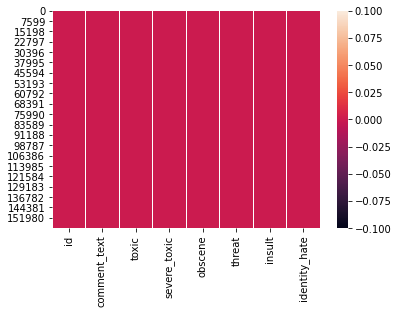

In [6]:
#visualising the null values
sns.heatmap(data.isnull())

In [7]:
cols=['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
data['Toxic']=data[cols].max(axis=1).apply(lambda x: "Toxic" if x ==1 else "Non-Toxic")

##### Data is highly imbalanced!!!

In [8]:
clean = len(data[data.Toxic=="Non-Toxic"])
toxic = len(data[data.Toxic=="Toxic"])

In [9]:
print("Toxic Comments count:",toxic)
print("toxic percentage %.2f"%(toxic/len(data)*100))

Toxic Comments count: 16225
toxic percentage 10.17


In [10]:
print("Toxic Comments count:",clean)
print("toxic percentage %.2f"%(clean/len(data)*100))

Toxic Comments count: 143346
toxic percentage 89.83


In [11]:
data= data[['id','comment_text','Toxic']]

In [12]:
count =data.comment_text.str.len()
count.describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_text, dtype: float64

In [13]:
#count list contains the number of the counts for the labels
count=[clean,toxic]

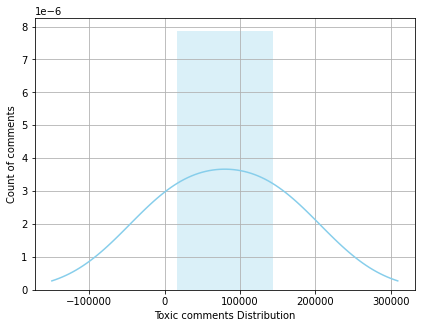

In [31]:
'''toxic comment distribution by removing the clean coments'''
plt.figure(figsize=(15, 5))
plt.subplot(121)
ax= sns.distplot(count,
                 kde=True,
                 color="skyblue",
                 hist_kws={"linewidth": 10,'alpha':0.3})
ax.set(xlabel='Toxic comments Distribution', ylabel='Count of comments')
plt.grid(True)

Mean length of comment before cleaning data: 394.073


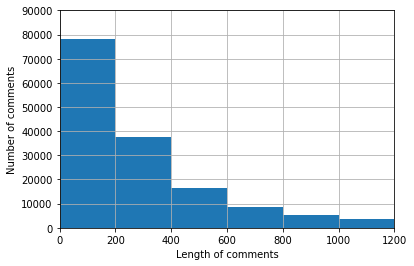

In [32]:
'''Average length decreaing while number of words/characters increasing...'''
comment=data['comment_text']
x = [len(comment[i]) for i in range(comment.shape[0])]
print('Mean length of comment before cleaning data: {:.3f}'.format(sum(x)/len(x)) )
bins = [1,200,400,600,800,1000,1200]
plt.hist(x, bins=bins)
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1200, 0, 90000])
plt.grid(True)
plt.show()

#### Check the comments length in each label...

In [45]:
cl = data[data.Toxic=="Non-Toxic"]
ntox = cl.comment_text.str.len()
t = data[data.Toxic=="Toxic"]
tox = t.comment_text.str.len()

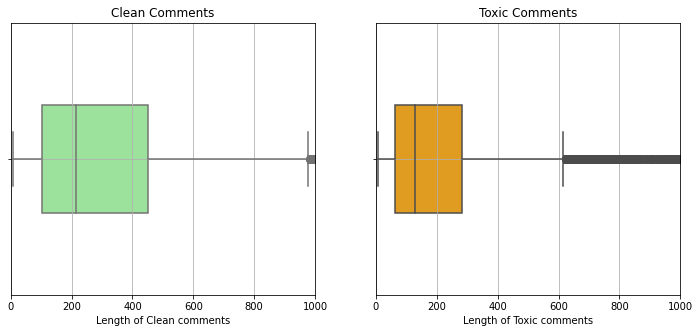

In [56]:
'''the most comments are upto 400 characters range and the comments haivng higher range are clean'''
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.boxplot(x=ntox,orient="h",color='lightgreen')
plt.axis([0, 1000,-1,1])
plt.xlabel('Length of Clean comments')
plt.title("Clean Comments")
plt.grid(True)

plt.subplot(122)
sns.boxplot(x=tox,orient="h",color='orange')
plt.axis([0, 1000,-1,1])
plt.xlabel('Length of Toxic comments')
plt.title("Toxic Comments")
plt.grid(True)

##### Confidence Interval representing the length of the comments are in which range???

100%|██████████| 1000/1000 [00:08<00:00, 122.37it/s]


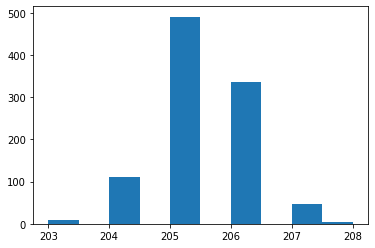

95.0 confidence interval of comments(word len) 204.0 and 207.0


In [18]:
import numpy
from matplotlib import pyplot
bootstrap =data.comment_text.str.len()
sample = bootstrap
# configure bootstrap
n_iterations = 1000
n_size = int(len(sample))

# run bootstrap
medians = list()
for i in tqdm(range(n_iterations)):
    # prepare train and test sets
    s = resample(sample, n_samples=n_size);
    m = numpy.median(s);
    #print(m)
    medians.append(m)

# plot scores
pyplot.hist(medians)
pyplot.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower =  numpy.percentile(medians, p)

p = (alpha+((1.0-alpha)/2.0)) * 100
upper =  numpy.percentile(medians, p)
print('%.1f confidence interval of comments(word len) %.1f and %.1f' % (alpha*100, lower, upper))

#### WordClouds

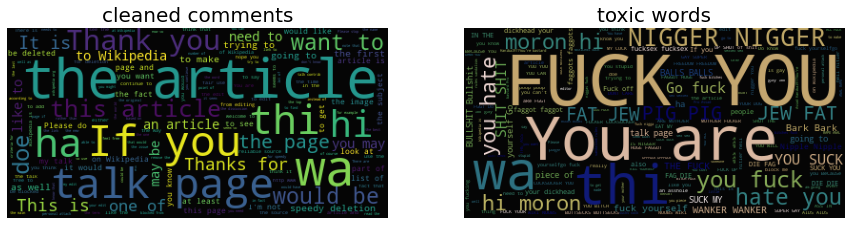

In [59]:
'''wordcloud visualisation to check the most common words in clean and toxic comments'''
#wordcloud for clean comments
plt.figure(figsize=(15, 5))
plt.subplot(121)
stopword = set(stopwords.words("english"))
subset=data[data.Toxic=='Non-Toxic']
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=1000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("cleaned comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)

'''frequent words in toxic comments'''
plt.subplot(122)
subset=data[data.Toxic=='Toxic']
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=1000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("toxic words", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth'), alpha=0.98)

### Text Cleaning

In [61]:
comm = data['comment_text']

In [62]:
'''text clening functions that replace short forms to full forms....'''
def decontracted(phrase):
# specific
    phrase = re.sub(r"won’t", "will not", phrase)
    phrase = re.sub(r"can’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [63]:
'''to remove the <.?/; and any numerical values from the text'''
def stripunc(X):
    return re.sub('[^A-Za-z]+',' ', str(X), flags=re.MULTILINE|re.DOTALL)

In [64]:
comm = comm.apply(decontracted) #cleaning functions are being applied on the text
comm = comm.apply(stripunc)

In [23]:
'''striping and lowering fn'''
def strip_lower(text):
    text = text.apply(lambda x:x.strip().lower())
    return text

In [24]:
comm = strip_lower(comm)

In [86]:
#spacy stopwords....
stop_rots = sp.Defaults.stop_words

In [87]:
#removing some words because it may change the non-toxic to toxic....
stop_rots.remove("n't")
stop_rots.remove("no")
stop_rots.remove("not")

In [27]:
#function removes the stopwords and lemmatize the text...
#wordnet lemmatizer has been used
def lemmatize(text):
    lm= WordNetLemmatizer()
    text = text.apply(lambda x: " ".join([lm.lemmatize(word,pos='v') for word in x.split(" ") if word not in stop_rots]))
    return text

In [28]:
data['comments'] = lemmatize(comm)

In [34]:
data = data[['id','comments','Toxic']]

### Load data

In [36]:
#saving the dataframe to pickle file
# data.to_pickle('cleaned_data.pkl')

In [69]:
data = pd.read_pickle('cleaned_data.pkl')

In [70]:
data.isnull().sum()

id          0
comments    0
Toxic       0
dtype: int64

<i><b>Under sampling of the non-toxic data, as the comments of longer length are moslty clean and donot contains the less amount of data.So removed the comments whose length >50. </b></i><br>
<i><b> And somehow it improves the F1 score by little undersmapling...</b></i>

In [71]:
#as most of comments larger are clean so we are undersampling
data = data[data.comments.str.len()<400]

In [72]:
print("Data shape after removing the comments",data.shape)

Data shape after removing the comments (138412, 3)


### Feature engineering

In [73]:
X = data[['id','comments']]
y = data[['Toxic']] 

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.20,random_state =0, shuffle =False)

In [75]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test =y_test.reset_index(drop=True)

In [76]:
print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("Train Labels shape:",y_train.shape)
print("Test Labels shape:",y_test.shape)

X_train shape: (110729, 2)
X_test shape: (27683, 2)
Train Labels shape: (110729, 1)
Test Labels shape: (27683, 1)


In [77]:
'''tfidf vectoriser has been used as it is far better than bag of words approach.'''
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(ngram_range=(1,2),min_df=3, max_df=0.9,use_idf=True,
               smooth_idf=1, sublinear_tf=1 )

In [78]:
train = tf.fit_transform(X_train['comments'])

In [48]:
test = tf.transform(X_test['comments'])

In [49]:
print("Comments Dimensions:",train.shape)
print("Non-Zeros:",train[0].nonzero())

Comments Dimensions: (110729, 108893)
Non-Zeros: (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32), array([ 67572,  92705,  93520,  78649,  63289,  31166,  60282,  63758,
        80213,  57015,  39521,  27860,  30906,  79960,  66790,  92452,
        93427,  78321,  31160,  26104, 108632,  60039, 102315,  35801,
        16756, 101323,  61619,  80060,  31933,  57014,  39519, 100531,
        27134,  30899], dtype=int32))


In [50]:
test = tf.transform(X_test['comments'])
print("Comments Dimensions:",test.shape)
print("Non-Zeros:",test[0].nonzero())

Comments Dimensions: (27683, 108893)
Non-Zeros: (array([0, 0, 0, 0, 0, 0, 0], dtype=int32), array([95940, 59303, 54465, 32857, 28889, 10790,  7950], dtype=int32))


#### SMOTE (Oversampling)

<i>Applying SMOTE for the sythetic data points generation beacuse of the class imbalacing problem...</i>

In [51]:
y = y_train.to_numpy()

In [52]:
'''applying the smote to the miority class only.'''
sm = SMOTE(random_state = 10,sampling_strategy='minority',k_neighbors=15,n_jobs=-1)
sam_train, sam_y = sm.fit_sample(train, y.ravel())  #train is tfidf output maxtrix and y is numpy.ndarray()

In [53]:
#printing the shapes of the resampled x and y
print(sam_train.shape)
print(sam_y.shape)

(197432, 108893)
(197432,)


### Baseline Models...

### 1. Logistic Regression

In [57]:
'''Hyperparameter tunning using Grid Search CV'''
model = LogisticRegression(class_weight='balanced')
penalty = ['l2','l1']
c_values = [10, 1.0, 0.1]
solvers = ['lbfgs', 'sag']
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1,
                           cv=5,verbose=1, scoring='f1_macro',error_score=0)
grid_result = grid_search.fit(sam_train, sam_y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.1min finished


In [58]:
print("Best params are:",grid_result.best_params_)

Best params are: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


In [59]:
print("Best estimators are:",grid_result.best_estimator_)

Best estimators are: LogisticRegression(C=10, class_weight='balanced')


In [60]:
#predciting the test set...
best = grid_result.best_estimator_.predict(test)
pre = grid_result.predict(test)

In [61]:
print("Accuracy on test set is: %.2f"%accuracy_score(pre, y_test))

Accuracy on test set is: 0.93


##### Classification report & Confusion matrix

F1- Score with Logistic regression is 0.96 for non-toxic and 0.71 for toxic

In [62]:
print("Classification Report....")
target_names = ['0','1']
print(classification_report(y_test, pre, target_names=target_names))

Classification Report....
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     23927
           1       0.64      0.79      0.71      2930

    accuracy                           0.93     26857
   macro avg       0.81      0.87      0.83     26857
weighted avg       0.94      0.93      0.93     26857



In [102]:
print("F1-score for logistic regression is:",f1_score(y_test, pre, average='macro'))

F1-score for logistic regression is: 0.8335545453376121


In [166]:
'''confusion matrix function'''
def conf_mat(true,pred):
    labels = ['Non-Toxic', 'Toxic']
    cm = confusion_matrix(y_test, pred, labels)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True,cmap="summer",fmt='g', ax = ax) 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

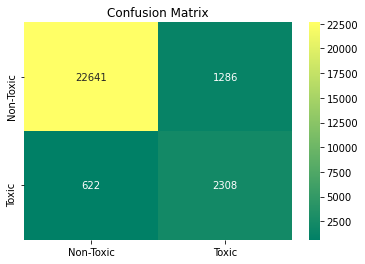

In [35]:
conf_mat(y_test,pre)

In [157]:
#saving the model
filename = 'log2.sav'
joblib.dump(grid_result, filename)

### 2. Random Forest

In [29]:
'''Hyperparameter tunning using Grid Search CV'''

params ={'min_samples_leaf': [5],'min_samples_split': [12],'n_estimators': [100,150]}

model = GridSearchCV(RandomForestClassifier(oob_score=True,n_jobs=-1), param_grid=params,cv=5, n_jobs=-1, 
                     scoring='f1_macro',return_train_score=True,verbose=1)
model = model.fit(sam_train, sam_y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 14.8min finished


In [30]:
#generating the predicted results
pred = model.best_estimator_.predict(test)

In [31]:
print("Accuracy on test set is: %.2f"%accuracy_score(pred, y_test))

Accuracy on test set is: 0.94


##### Classification report & Confusion matrix

F1- Score with Random forest is 0.96 for non-toxic and 0.67 for toxic, which is less than Logistic regression

In [32]:
print("Classification Report....")
target_names = ['0','1']
print(classification_report(y_test, pred, target_names=target_names))

Classification Report....
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     23927
           1       0.76      0.60      0.67      2930

    accuracy                           0.94     26857
   macro avg       0.86      0.79      0.82     26857
weighted avg       0.93      0.94      0.93     26857



In [37]:
print("F1-score for Random Forest is:")
f1_score(y_test, pred, average='macro')

F1-score for Random Forest is:


0.8178629176285153

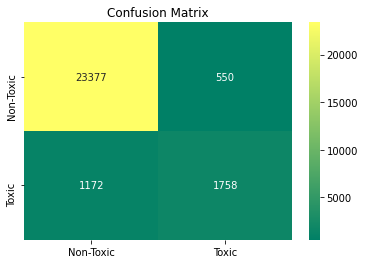

In [36]:
conf_mat(y_test,pred)

In [51]:
#saving the model
filename = 'rf2.sav'
joblib.dump(model, filename)

['rf2.sav']

In [171]:
# loaded_model = joblib.load('rf2.sav')

### 3. Linear SVC

In [66]:
from sklearn.svm import LinearSVC
'''Hyperparameter tunning using Grid Search CV'''

params ={'C': [0.01,0.1,1.0,10],'max_iter': [1000,1500],'dual':[True,False]}

clf = GridSearchCV(LinearSVC(class_weight='balanced'), param_grid=params,cv=5, n_jobs=-1, 
                     scoring='f1_macro',return_train_score=True,verbose=1)
clf = clf.fit(sam_train, sam_y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.5min finished


In [67]:
svc_pred = clf.best_estimator_.predict(test)

In [68]:
print("Accuracy on test set is: %.2f"%accuracy_score(svc_pred, y_test))

Accuracy on test set is: 0.92


##### Classification report & Confusion matrix

F1- Score with Linear SVC is 0.96 for non-toxic and 0.67 for toxic

In [69]:
print("Classification Report....")
target_names = ['0','1']
print(classification_report(y_test, svc_pred, target_names=target_names))

Classification Report....
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     23927
           1       0.62      0.74      0.67      2930

    accuracy                           0.92     26857
   macro avg       0.79      0.84      0.81     26857
weighted avg       0.93      0.92      0.92     26857



In [70]:
print("F1-score for SVC is:")
f1_score(y_test, pred, average='macro')

F1-score for SVC is:


0.8178629176285153

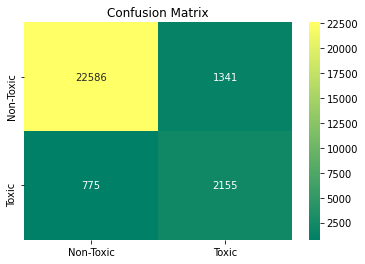

In [71]:
conf_mat(y_test,svc_pred)

### 4.Naive Bays

In [54]:
'''Hyperparameter tunning using Grid Search CV'''
params = {'alpha':[10,100]}
nav = GridSearchCV(MultinomialNB(), param_grid=params,cv=5,n_jobs=-1,
                   scoring='accuracy',verbose=1)
nv = nav.fit(sam_train, sam_y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.7s finished


In [55]:
nv.best_params_

{'alpha': 10}

In [56]:
pr =nv.best_estimator_.predict(test)

In [57]:
print("Accuracy on test set is: %.2f"%accuracy_score(pr, y_test))

Accuracy on test set is: 0.94


##### Classification report & Confusion matrix

F1- Score with Naive bays is 0.96 for non-toxic and 0.72 for toxic and it is highest

In [58]:
print("Classification Report....")
target_names = ['0','1']
print(classification_report(y_test, pr, target_names=target_names))

Classification Report....
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     24702
           1       0.70      0.75      0.72      2981

    accuracy                           0.94     27683
   macro avg       0.84      0.85      0.84     27683
weighted avg       0.94      0.94      0.94     27683



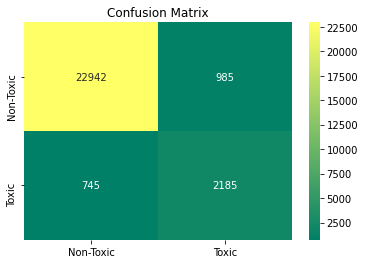

In [167]:
conf_mat(y_test,pr)

In [59]:
filename = 'naive2.sav'
joblib.dump(nav, filename)

['naive2.sav']

In [60]:
print("F1-Score of Naive Bays:",f1_score(y_test, pr, average='macro'))

F1-Score of Naive Bays: 0.8441270406865529


In [61]:
nav.best_params_

{'alpha': 10}

#### Testing

In [57]:
#imported the naive bays model as it is having highest F1 score...
loaded_model = joblib.load('naive2.sav')

In [58]:
# as above we used it inside function
lm= WordNetLemmatizer()

In [118]:
'''clean function'''
def clean(text):
    text = decontracted(text)
    text = stripunc(text)
    text = text.strip().lower()
    text = text.split(" ")
    word= [" ".join([lm.lemmatize(w,pos='v') for w in text if w not in stop_rots])]
    text = tf.transform(word)
    return text

In [121]:
loaded_model.predict(clean("you are nyc"))

array(['Non-Toxic'], dtype='<U9')

In [120]:
loaded_model.predict(clean("you are dog!!!!>>>>/??{}"))

array(['Toxic'], dtype='<U9')